# Simple CNN Model test notebook

Just trying out if the training pipeline works

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !

ZOOM = True
ZOOM_SIZE = 11
NPIXEL_AFTERZOOM = ZOOM_SIZE if ZOOM else npixel
CENTERING = True


In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from helpers import *

import sys
sys.path.append('..')

from simpleCNNModel import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Load the model weights
loaded_model = DiffusionPredictorCNN().to(device)
#loaded_model = load_model_weights(loaded_model, "diffusion_model_weights.pth")
#loaded_model = load_model_weights(loaded_model, "ZOOMED_IMAGE_diffusion_model_weights.pth")

model = loaded_model

In [5]:
def zoom_image(image, zoom_size = ZOOM_SIZE):
    """
    to zoom on image (the real image) to make it similar to the one we have created
    """

    # Get the height and width of the image
    _, H, W = image.shape

    # Find the center of the image
    center_row, center_col = H // 2, W // 2

    # Calculate the boundaries for the 11x11 crop
    half_zoom = zoom_size // 2
    start_row = center_row - half_zoom
    end_row = center_row + half_zoom + 1
    start_col = center_col - half_zoom
    end_col = center_col + half_zoom + 1

    # Extract the zoomed-in region
    return image[:, start_row:end_row, start_col:end_col]

In [ ]:
# Takes 30 seconds to run with N=100 images (on my laptop)
# Takes 16 seconds to run with N=100 images (on my pc)
# Simulated dataset
N = 1000  # Number of samples
images, estimatedDs = np.empty((nparticles, 0, NPIXEL_AFTERZOOM, NPIXEL_AFTERZOOM)), np.array([])
for i in range(nframes):

    if CENTERING:
        images, estimatedDs = generateImagesAndEstimateD(N, nframes, ZOOM_SIZE, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue, centering=True)



    else:
        image, estimatedD = generateImagesAndEstimateD(N, 1, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue, centering=False)

        if ZOOM: 

            old_image = image.copy()
            image = np.zeros((nparticles, 1, NPIXEL_AFTERZOOM, NPIXEL_AFTERZOOM))
    
            for i in range(nparticles):
                image[i,:,:,:] = zoom_image(old_image[i,:,:,:])

        images = np.concatenate((images, image), axis=1) 
        estimatedDs = np.append(estimatedDs, estimatedD)

if not CENTERING: estimatedDs = estimatedDs.reshape(-1, nparticles).mean(axis=0)
print(images.shape, estimatedDs.shape)
# Add channel dimension to images: (N, 8, 64, 64) -> (N, 8, 1, 64, 64)
images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)
print(images.shape)
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# uncomment next line if you want to train a new model and note use the previous existing weigths
#model = DiffusionPredictorCNN().to(device)

# Train the model
trained_model, loss_history = train_model(
    model, 
    images, 
    estimatedDs, 
    device,
    epochs=100, 
    batch_size=16, 
    learning_rate=0.001, 
)

# Save the model weights
#save_model_weights(trained_model, "diffusion_model_weights.pth")



ValueError: not enough values to unpack (expected 3, got 2)

In [66]:
weight_name = "ZOOMED_IMAGE_diffusion_model_weights.pth" if ZOOM else "FULL_IMAGE_diffusion_model_weights.pth"

if CENTERING:
    weight_name = "CENTERED_" + weight_name

In [67]:
# Save the model weights
save_model_weights(trained_model, weight_name)

Model weights saved to CENTERED_FULL_IMAGE_diffusion_model_weights.pth


In [68]:
# Load the model weights
loaded_model = DiffusionPredictorCNN().to(device)
loaded_model = load_model_weights(loaded_model, weight_name)

Model weights loaded from CENTERED_FULL_IMAGE_diffusion_model_weights.pth


Image loaded from ../refImage.npy
(8, 64, 64)
Real D value: 13837. Model estimated value: 376.0


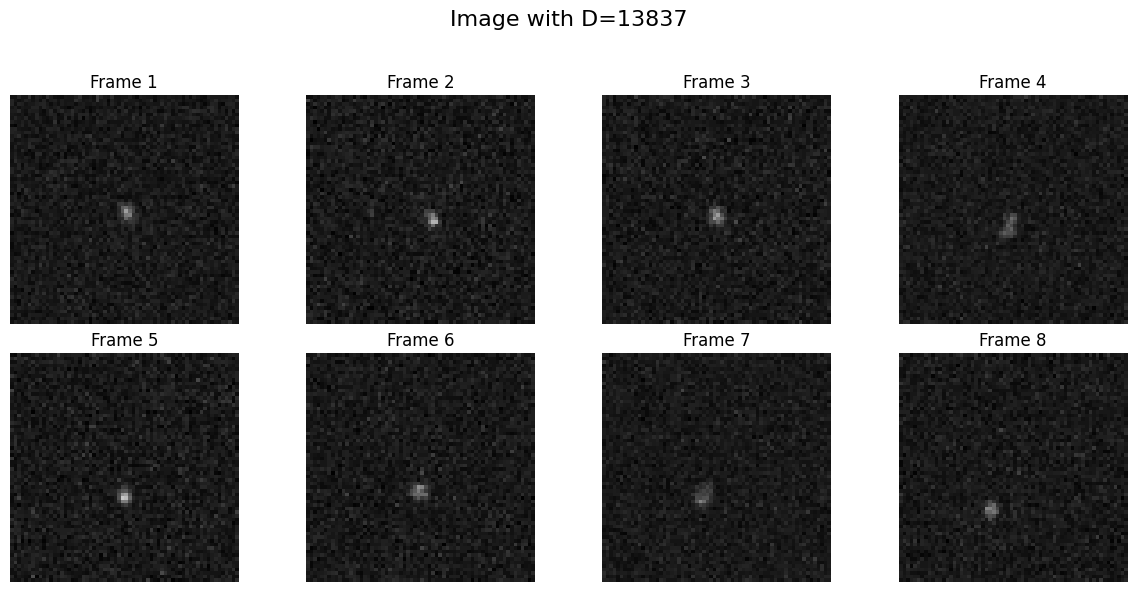

In [70]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImage.npy") 


im = load_image("../refImage.npy")
estD = 13837

if ZOOM: im = zoom_image(im)
print(im.shape)

modelEstimation = predict_diffusion_coefficients(loaded_model, im,device )

print(f"Real D value: {estD}. Model estimated value: {round(modelEstimation,0)}")
plot_image_frames(im,f"Image with D={estD}")

